# References
* https://developers.google.com/maps/solutions/store-locator/nyc-subway-locator
* https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html
* https://pypi.org/project/geojson/
* https://gis.stackexchange.com/questions/127607/area-in-km-from-polygon-of-coordinates

## Python packages
* shapely: conda install -c esri shapely 
* pyproj: conda install -c esri pyproj

## Download raw data

## Helper methods

In [1]:
import pandas as pd
import numpy as np

In [2]:
from pathlib import Path
import json

def read_json(filename):
    return json.loads(Path(filename).read_text())

## Boundaries
* NYC Opendata
    * [Borough Boundaries](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)
* StreetEasy
    * https://streeteasy-market-data-download.s3.amazonaws.com/chart/v2/data/neighbs.json 
    * https://streeteasy-market-data-download.s3.amazonaws.com/chart/v2/data/nyc3.json 

In [3]:
neighborhood_boundaries = read_json('./street_easy/neighborhood_boundaries.json')

In [4]:
import pyproj    
import shapely
import shapely.ops as ops

from functools import partial
from shapely.geometry import Point, Polygon

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def get_polygon_area(polygon):
    tranformed_polygon = ops.transform(
        partial(
            pyproj.transform,
            pyproj.Proj(init='EPSG:4326'),
            pyproj.Proj(
                proj='aea',
                lat_1=polygon.bounds[1],
                lat_2=polygon.bounds[3])
        ),
        polygon
    )
    return tranformed_polygon.area

def process_neighborhood_boundaries():
    boundary_map = {}
    for n in neighborhood_boundaries['features']:
        props = n['properties']
        borough = props['Borough']
        name = props['name']
        coords = n['geometry']['coordinates'][0]
        polygon = Polygon(coords)
        area = get_polygon_area(polygon)  # in square meters
        boundary_map[name] = borough, polygon, area
    return boundary_map

all_neighborhoods = process_neighborhood_boundaries()

5693715.308878865


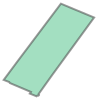

In [5]:
_, upper_west_side_polygon, area = all_neighborhoods['Upper West Side']
print(area)
upper_west_side_polygon

In [6]:
def in_neighborhood(name, longitude, latitude):
    point = Point(longitude, latitude)
    _, polygon, _ = all_neighborhoods[name]
    return point.within(polygon)

def get_neighborhood(longitude, latitude):
    for name in all_neighborhoods:
        if in_neighborhood(name, longitude, latitude):
            return name
    return 'unknown'
        
def get_borough(name):
    if name in all_neighborhoods:
        return all_neighborhoods[name][0]
    return 'unknown'

def get_area(name):
    if name in all_neighborhoods:
        return all_neighborhoods[name][2]
    return np.nan

In [7]:
get_neighborhood(-73.991070, 40.730054)

'East Village'

In [8]:
def add_neighborhood_columns(df):
    if 'latitude' not in df or 'longitude' not in df:
        raise ValueError('missing latitude or longitude columns')
    new_df = df.copy()
    new_df['neighborhood'] = new_df.apply(
        lambda row: get_neighborhood(row['longitude'], row['latitude']), 
        axis=1
    )
    new_df['borough'] = new_df.apply(
        lambda row: get_borough(row['neighborhood']), 
        axis=1
    )
    new_df['area'] = new_df.apply(
        lambda row: get_area(row['neighborhood']), 
        axis=1
    )
    return new_df

## Subways
* [Subway Stations](https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49)

In [9]:
subway_stations = read_json('./nyc_opendata/subway_stations.json')

In [10]:
def process_subway_stations():
    records = []
    for s in subway_stations['features']:
        props = s['properties']
        longitude, latitude = s['geometry']['coordinates']
        props['longitude'] = longitude
        props['latitude'] = latitude
        records.append(props)
    df = pd.DataFrame.from_records(records)
    df = df.drop(columns=['url', 'objectid', 'notes'])
    df = add_neighborhood_columns(df)
    return df

subway_stations_df = process_subway_stations()
subway_stations_df

,name,line,longitude,latitude,neighborhood,borough,area
0,Astor Pl,4-6-6 Express,-73.991070,40.730054,East Village,Manhattan,1.847620e+06
1,Canal St,4-6-6 Express,-74.000193,40.718803,Chinatown,Manhattan,3.478105e+05
2,50th St,1-2,-73.983849,40.761728,Midtown,Manhattan,1.862342e+06
3,Bergen St,2-3-4,-73.974999,40.680862,Prospect Heights,Brooklyn,9.071918e+05
4,Pennsylvania Ave,3-4,-73.894886,40.664714,East New York,Brooklyn,1.617295e+07
...,...,...,...,...,...,...,...
468,Coney Island - Stillwell Av,D-F-N-Q,-73.981236,40.577281,Coney Island,Brooklyn,3.564659e+06
469,34th St - Hudson Yards,7-7 Express,-74.002197,40.755446,Midtown West,Manhattan,3.273132e+06
470,72nd St,Q,-73.958362,40.768803,Upper East Side,Manhattan,4.861989e+06
471,86th St,Q,-73.951771,40.777861,Upper East Side,Manhattan,4.861989e+06


In [11]:
subway_stations_df[(subway_stations_df.borough == 'unknown') | (subway_stations_df.neighborhood == 'unknown')]

,name,line,longitude,latitude,neighborhood,borough,area
55,72nd St,A-B-C,-73.976337,40.775519,unknown,unknown,NaN
56,96th St,A-B-C,-73.964602,40.791619,unknown,unknown,NaN
160,103rd St,A-B-C,-73.961370,40.796061,unknown,unknown,NaN
162,81st St,A-B-C,-73.972098,40.781346,unknown,unknown,NaN
164,86th St,A-B-C,-73.968828,40.785823,unknown,unknown,NaN
355,5th Ave - 59th St,N-R-W,-73.973347,40.764811,unknown,unknown,NaN
383,Union Sq - 14th St,L,-73.990670,40.734763,unknown,unknown,NaN
455,Woodlawn,4,-73.878751,40.886037,unknown,unknown,NaN


In [12]:
subway_station_counts = subway_stations_df[['name', 'neighborhood']].groupby('neighborhood').count().rename(columns={'name': 'subway_station_count'})
subway_station_counts

,subway_station_count
neighborhood,
Astoria,6
Bay Ridge,4
Bedford Park,4
Bedford-Stuyvesant,16
Bensonhurst,5
...,...
Windsor Terrace,2
Woodhaven,5
Woodside,4


In [13]:
subway_stations_df.to_parquet('./cleaned_data/subway_stations.parquet')

## NYPD Complaints
- [NYPD Complaint Data Current (Year To Date)](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Current-Year-To-Date-/5uac-w243)

In [15]:
nypd_complaints = read_json('./nyc_opendata/nypd_complaints.json')

In [16]:
def process_nypd_complaints():
    records = []
    props_to_keep = ['law_cat_cd', 'ofns_desc', 'vic_sex', 'susp_sex', 'cmplnt_fr_dt']
    for s in nypd_complaints['features']:
        props = {k: v for k, v in s['properties'].items() if k in props_to_keep}
        longitude, latitude = s['geometry']['coordinates']
        props['longitude'] = longitude
        props['latitude'] = latitude
        records.append(props)
    df = pd.DataFrame.from_records(records)
    df = df.rename(columns={
        'cmplnt_fr_dt': 'date',
        'law_cat_cd': 'category',
        'ofns_desc': 'offense',
    })
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = add_neighborhood_columns(df)
    return df

nypd_complaints_df = process_nypd_complaints()
nypd_complaints_df

,vic_sex,offense,date,susp_sex,category,longitude,latitude,neighborhood,borough,area
0,F,ROBBERY,2019-12-31,U,FELONY,-73.881681,40.838026,East Tremont,Bronx,2.211749e+06
1,F,PETIT LARCENY,2019-12-30,None,MISDEMEANOR,-73.945657,40.800334,Central Harlem,Manhattan,4.387418e+06
2,M,FELONY ASSAULT,2019-12-24,M,FELONY,-73.939376,40.669832,Crown Heights,Brooklyn,6.261658e+06
3,D,PETIT LARCENY,2019-12-30,F,MISDEMEANOR,-73.908014,40.873671,Marble Hill,Manhattan,3.446919e+05
4,M,PETIT LARCENY,2019-12-30,None,MISDEMEANOR,-73.994529,40.760935,Midtown West,Manhattan,3.273132e+06
...,...,...,...,...,...,...,...,...,...,...
461706,M,VEHICLE AND TRAFFIC LAWS,2019-01-03,None,MISDEMEANOR,-73.905708,40.669126,Brownsville,Brooklyn,3.900906e+06
461707,M,FELONY ASSAULT,2019-01-02,F,FELONY,-73.733559,40.692214,Cambria Heights,Queens,3.056673e+06
461708,D,PETIT LARCENY,2019-01-05,F,MISDEMEANOR,-73.922373,40.609900,Mill Basin,Brooklyn,2.458728e+06
461709,M,ASSAULT 3 & RELATED OFFENSES,2019-01-04,None,MISDEMEANOR,-73.988372,40.756642,Midtown,Manhattan,1.862342e+06


In [17]:
nypd_complaints_counts = nypd_complaints_df[['date', 'neighborhood']].groupby('neighborhood').count().rename(columns={'date': 'nypd_complaints_count'})
nypd_complaints_counts

,nypd_complaints_count
neighborhood,
Annadale,209
Arden Heights,79
Arlington,484
Arrochar,126
Astoria,6437
...,...
Woodlawn,242
Woodrow,94
Woodside,1393


In [18]:
nypd_complaints_df.to_parquet('./cleaned_data/nypd_complaints.parquet')

## Parks
* [Parks Properties](https://nycopendata.socrata.com/Recreation/Parks-Properties/enfh-gkve)

In [19]:
parks_properties = read_json('./nyc_opendata/parks_properties.json')

In [20]:
def process_parks_properties():
    records = []
    for s in parks_properties['features']:
        props = s['properties']
        coords = s['geometry']['coordinates'][0][0]  # polygon coordinates
        centroid = Polygon(coords).centroid
        props['longitude'] = centroid.x
        props['latitude'] = centroid.y
        records.append(props)
    df = pd.DataFrame.from_records(records)
    df = df[['latitude', 'longitude', 'typecategory', 'signname', 'waterfront', 'acres']]
    df = df.rename(columns={
        'typecategory': 'category',
        'signname': 'name',
    })
    df = add_neighborhood_columns(df)
    return df

parks_properties_df = process_parks_properties()
parks_properties_df

,latitude,longitude,category,name,waterfront,acres,neighborhood,borough,area
0,40.756623,-73.727964,Jointly Operated Playground,Challenge Playground,False,2.035,Little Neck,Queens,2.064722e+06
1,40.674433,-73.865252,Neighborhood Park,Robert E. Venable Park,False,2.939,East New York,Brooklyn,1.617295e+07
2,40.525576,-74.184467,Nature Area,Kingdom Pond Park,False,4.22,Huguenot,Staten Island,4.679218e+06
3,40.876281,-73.891882,Neighborhood Park,Harris Park,False,15.32,Bedford Park,Bronx,1.525273e+06
4,40.842200,-73.888758,Strip,Park,False,0.023,East Tremont,Bronx,2.211749e+06
...,...,...,...,...,...,...,...,...,...
2012,40.813785,-73.830495,Flagship Park,Ferry Point Park,True,413.8,Throgs Neck,Bronx,1.059441e+07
2013,40.813069,-73.962079,Neighborhood Park,Sakura Park,False,2.067,Morningside Heights,Manhattan,1.258679e+06
2014,40.701160,-73.987588,Parkway,Park,False,0.047,DUMBO,Brooklyn,6.860450e+05
2015,40.701933,-73.933035,Neighborhood Park,Green Central Knoll,False,2.741,Bushwick,Brooklyn,6.058049e+06


In [21]:
parks_properties_counts = parks_properties_df[['name', 'neighborhood']].groupby('neighborhood').count().rename(columns={'name': 'parks_count'})
parks_properties_counts

,parks_count
neighborhood,
Annadale,8
Arden Heights,1
Arlington,5
Arrochar,2
Astoria,30
...,...
Woodlawn,1
Woodrow,2
Woodside,13


In [22]:
parks_properties_df.to_parquet('./cleaned_data/parks_properties.parquet')

## Schools
* [2020 DOE High School Directory](https://data.cityofnewyork.us/Education/2020-DOE-High-School-Directory/23z9-6uk9)
* [2019 - 2020 School Locations](https://data.cityofnewyork.us/Education/2019-2020-School-Locations/wg9x-4ke6)

In [23]:
school_locations = read_json("./nyc_opendata/school_locations.json")

In [24]:
def process_school_locations():
    df = pd.DataFrame.from_records(school_locations)
    df = df[['latitude', 'longitude', 'location_category_description', 'location_name']]
    df = df.rename(columns={
        'location_category_description': 'category',
        'location_name': 'name',
    })
    df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
    df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
    df = add_neighborhood_columns(df)
    return df

school_locations_df = process_school_locations()
school_locations_df

,latitude,longitude,category,name,neighborhood,borough,area
0,40.648959,-74.011420,Elementary,P.S. 001 The Bergen,Sunset Park,Brooklyn,5.880031e+06
1,40.656423,-73.951575,Junior High-Intermediate-Middle,Parkside Preparatory Academy,Prospect Lefferts Gardens,Brooklyn,1.188548e+06
2,40.682311,-73.955219,Elementary,P.S. 003 The Bedford Village,Bedford-Stuyvesant,Brooklyn,8.300323e+06
3,40.658500,-73.879276,Elementary,P.S. K004,East New York,Brooklyn,1.617295e+07
4,40.685241,-73.921970,Elementary,P.S. 005 Dr. Ronald McNair,Bedford-Stuyvesant,Brooklyn,8.300323e+06
...,...,...,...,...,...,...,...
2185,40.814900,-73.917000,Elementary,Readnet Bronx Charter School,Mott Haven,Bronx,3.333991e+06
2186,40.821815,-73.886477,Elementary,Bronx Charter School for the Arts,Hunts Point,Bronx,5.131851e+06
2187,40.811051,-73.909363,High school,J. M. Rapport School Career Development,Mott Haven,Bronx,3.333991e+06
2188,40.830552,-73.886798,Secondary School,P.S. X811,Crotona Park East,Bronx,1.975787e+06


In [25]:
school_locations_counts = school_locations_df[['name', 'neighborhood']].groupby('neighborhood').count().rename(columns={'name': 'parks_count'})
school_locations_counts

,parks_count
neighborhood,
Annadale,1
Arrochar,1
Astoria,25
Auburndale,5
Bath Beach,4
...,...
Woodlawn,1
Woodrow,1
Woodside,4


In [26]:
school_locations_df.to_parquet('./cleaned_data/school_locations.parquet')

## Yelp Business

In [34]:
def read_yelp_business():
    content = Path('./yelp/yelp_academic_dataset_business.json').read_text()
    records =[]
    columns_to_keep = ['name', 'state', 'latitude', 'longitude', 'stars', 'review_count', 'categories']
    for line in content.splitlines():
        record = {k:v for k,v in json.loads(line).items() if k in columns_to_keep}
        records.append(record)
    return pd.DataFrame.from_records(records)

def process_yelp_business():
    df = read_yelp_business()
    df = df[df['state'] == 'NY']
    df = add_neighborhood_columns(df)
#     df = df[df['neighborhood'] != 'unknown']
    return df

In [35]:
yelp_business_df = process_yelp_business()
yelp_business_df

,name,state,latitude,longitude,stars,review_count,categories,neighborhood,borough,area
11316,US Immigration,NY,45.006670,-73.454383,3.5,3,Public Services & Government,unknown,unknown,NaN
13122,Contact Lens King,NY,44.985468,-73.424611,2.0,4,"Shopping, Personal Shopping, Eyewear & Opticia...",unknown,unknown,NaN
36116,Nathan's Famous,NY,44.981140,-73.458718,4.0,4,"Hot Dogs, Gas Stations, Burgers, Food Stands, ...",unknown,unknown,NaN
36930,China Buffet,NY,44.979672,-73.444904,2.5,4,"Restaurants, Buffets, Szechuan, Chinese, Canto...",unknown,unknown,NaN
41719,Lakeside Coffee,NY,44.993181,-73.364154,4.5,22,"Sandwiches, Restaurants, Salad, Coffee & Tea, ...",unknown,unknown,NaN
47496,Sandy's Deli & Catering,NY,44.992213,-73.363784,2.5,7,"Delis, Restaurants",unknown,unknown,NaN
51634,Maplefields Champ Irving,NY,44.980310,-73.454753,4.0,3,"Convenience Stores, Automotive, Gas Stations, ...",unknown,unknown,NaN
59197,Yves Rocher,NY,44.965140,-73.434300,4.0,3,"Beauty & Spas, Cosmetics & Beauty Supply, Shop...",unknown,unknown,NaN
63345,McDonald's,NY,44.981470,-73.459850,2.0,13,"Restaurants, Fast Food, Coffee & Tea, Food, Bu...",unknown,unknown,NaN
85450,Freeport Forwarding,NY,44.994101,-73.454979,4.5,3,"Local Services, Shipping Centers",unknown,unknown,NaN


## More to consider
* [New York City Population By Neighborhood Tabulation Areas](https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp)